# LCPB 22-23 Exercise 2 (Restricted Boltzmann Machines) 

<center><h1>Group 2307</h1></center>


<center><style>
table {
    font-size: 24px;
}
</style></center>

| Last Name          | First Name            |Matricola number|
|--------------------|-----------------------|----------------|
| Bertinelli         | Gabriele              |1219907 (tri)   |
| Cacciola           | Martina               |2097476         |
| Pervysheva         | Yelyzaveta            |2039398         |           
| Waththe Liyanage   | Wageesha Widuranga    |2078719         |

## Introduction

Restricted Boltzmann Machines (RBM) are a type of generative model that can learn a probability distribution over the input data in an unsupervised manner. RBMs are particularly useful for binary datasets, where the input features can take only binary values. RBMs have a wide range of applications in machine learning and have been used in the development of deep learning models.

The aim of RBMs is to learn a set of weights that allow the model to generate similar data to the input data. This is achieved by training the RBM on a set of input data and adjusting the weights to minimize the likelihood of generating the same input data. Once the RBM has been trained, it can be used to generate new data that is similar to the training data.

In this exercise we will train a RBM on a binary dataset representing polar (P) and non-polar (N) amino acids. The train will be performed with a series of techniques and remarks described in [Mehta et al. (2019)](https://www.sciencedirect.com/science/article/pii/S0370157319300766?via%3Dihub). After the traning will be complete, we will use our RBM to generate a new dataset and we will use it to denoise the original dataset from spurious bits.

## Importing packages

In [1]:
import numpy as np
import numpy.random as npr
import pandas as pd
import math
import gzip

# random seed for reproducibility
npr.seed(12345)

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 13
import seaborn as sns

from IPython.display import display_html

## Importing Dataset and defining initial variables

In [22]:
# Selecting the data we want to work with
CASE = 1
if CASE == 1:
    dname = 'DATA_b'
    A = 4
    M = 3
elif CASE == 2:
    dname = 'DATA_c'
    A = 6
    M = 2

fname = dname + '/x_RBM_q0.1.dat'

# loading data: each row is a list of visible units
# NOTE: data "x" here is named "v" for "visible
v = np.loadtxt(fname, delimiter=' ', dtype=int)

# Store in v0, because later we will shuffle v
v_0 = np.copy(v)

# N=size of input
N = len(v)

# L=size of each sample
L = len(v[1])

# If SPINS = True, values in {-1, +1}, otherwise {0, 1}
SPINS = False

if SPINS:
    # sigmoid takes into account energy diff = 2
    GAP = 2
    # convert 0, 1 -> -1, 1
    v = 2 * v - 1
    VMIN = -1 
else:
    GAP = 1
    VMIN = 0
    
for i in range(min(12, N)):
    if SPINS: print(v_0[i], "\n->", v[i])
    else: print(v[i])

# Range of each initial weight
sigma = np.sqrt(4 / float(L + M))

# Initial weights from a normal distribution
w = sigma * npr.randn(L, M)
a = sigma * np.random.randn(L)
b = np.zeros(M)

print("w[:3] =", w[:3])
print("a =", a[:3])
print('...')

w_0, a_0, b_0 = np.copy(w), np.copy(a), np.copy(b)

[0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0]
[0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1]
[0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1]
[0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0]
[0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0]
[0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0]
[0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0]
[0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1]
[1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0]
[0 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0]
[0 0 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0]
[0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0]
w[:3] = [[ 0.06102207  0.2120136  -0.08203482]
 [-1.56192137 -0.63393106 -0.14464197]
 [-0.29063496  0.5451946  -0.28509788]]
a = [-0.27258456 -0.96376445  0.67236314]
...


## Reading weights with [0,1] and [-1,+1]

RBMs can be trained with both [0,1] and [-1,+1] spins, depending on the specific application and the nature of the input data.

When using [0,1] spin, the `sigmoid` activation function is typically used, which maps the input values to the range [0,1]. This makes it easier to read and interpret the weights. However, when using [-1,+1] spin, a different activation function must be chosen. This is because the range of the input values is different, and the sigmoid function is not suitable. Some examples of activation functions that can be used with [-1,+1] spin are the hyperbolic tangent (`tanh`) and the Rectified Linear Unit (`ReLU`) function.

When we refer to "reading weights" in the context of RBMs, we are talking about the values of the weight matrix (`w` in the code) that connects the visible and hidden units. These weights represent the strength of the connections between the units and are adjusted during the training process to learn the probability distribution over the input data. By reading the values of the weights, we can gain insights into how the RBM is representing the input data and potentially use this information for applications such as feature learning or anomaly detection.

Given that we use the sigmoid function in our code, all subsequent analysis will be performed with `SPIN=False`, i.e. [0,1], although the code is suitable for both cases.

## Original Dataset visualization

In [23]:
def is_one(cell_value):
    color0 = 'background-color: blue; color: white'
    color1 = 'background-color: cyan;'
    if type(cell_value) in [float, int]:
        if cell_value == 1:
            return color1
    return color0

N1=12
df0 = pd.DataFrame(v_0[:N1])

df0s = df0.style.set_table_attributes("style='display:inline'")
df0s.applymap(is_one)
sty = [dict(selector="caption",props=[("font-size", "150%")])]
df0s.set_caption('Original').set_table_styles(sty)

display_html(df0s._repr_html_(), raw=True)

df=df0
t=[i for i in range(N1)]
g = pd.Categorical(df[t]).codes # convert groups to indices  
df.style.apply(
    lambda x: ['background-color: {}'.format("#FFCCCC") for i in g], 
    # comment the 2nd line if working w/ case 0 or 1. Otherwise comment the 1st one
    subset=[0,1,2,3, 8,9,10,11, 16,17,18,19 ]
    #subset=[0,1,2,3,4,5, 12,13,14,15,16,17, 23,24,25,26,27,28,29]
)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0
1,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1
2,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1
3,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0
4,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0
5,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0
6,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0
7,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1
8,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0
9,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0
1,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1
2,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1
3,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0
4,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0
5,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0
6,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0
7,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1
8,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0
9,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0


## Defining "tree" plot function

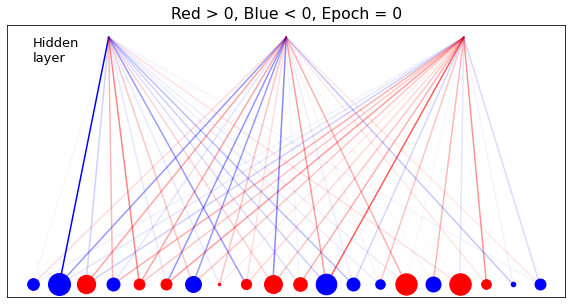

In [24]:
(x_v, y_v) = (np.zeros(L), np.linspace(-0.5, 0.5, L))
(x_h, y_h) = (np.ones(M), np.linspace(-0.35, 0.35, M))

def mycolor(value):
    if value > 0: return 'red'
    elif value < 0: return 'blue'
    return 'black'

# plot network with weights and units, all color-coded
def plotgraph(epoch=0):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    # remove ticks
    ax.tick_params(left=False, bottom=False)
    ax.xaxis.set_major_formatter(mpl.ticker.NullFormatter())
    ax.yaxis.set_major_formatter(mpl.ticker.NullFormatter())

    # scale for line width based on max weight
    lw_scale = 1 / abs(w).max()
    for i in range(L):
        for j in range(M):
            ex = (y_v[i], y_h[j])
            ey = (x_v[i], x_h[j])
            col = mycolor(w[i][j])
            ax.plot(ex, ey, col, zorder=1, alpha=lw_scale*abs(w[i][j]))

    # scale for circles representing the units
    c_scale = 500
    
    # plot visible units
    for i in range(L):
        ax.scatter(y_v[i], x_v[i], s=c_scale * abs(a[i]),
                   zorder=2, c=mycolor(a[i]))

    # plot hidden units (with square markers)
    for j in range(M):
        ax.scatter(y_h[j], x_h[j], s=min(300, c_scale * abs(b[j])),
                   zorder=2, c=mycolor(b[j]), marker='s')
    
    ax.set_title(f'Red > 0, Blue < 0, Epoch = {epoch}')
    ax.text(-0.5, 0.9, 'Hidden\nlayer')
    plt.show()

# Plotting relations between visible units and hidden variables;
# Lines are the weights;
# The size of the feaures (circles, squares, lines) is a proxy 
# for the abs value of the visible bias, hidden bias, weights;

plotgraph()

## Defining Activation Function w/ Backward one-hot encoding

Backward one-hot encoding is a technique used to convert a one-hot encoded vector back into its original categorical value.

Here we use the cumulative function of the probability of each vector, given by the exponential of act function, which in turn is given by the dot product between (*bias + hidden_v $\cdot$ weights*), of each four input vector, and the correspondant vector (the eigenvector). Than, based on that probability, after drawing a random number between 0 and 1, we extract the cathegorical value of the vector.

In [25]:
def activate(v_in, wei, bias, phase):
    act = bias + np.dot(v_in, wei)

    #list of -1 or 0 (SPINS = True or False)
    v_out = np.full(act.shape, VMIN, dtype=int)

    if phase == 1:
        # no one-hot blocks in the output
        p = npr.random_sample((len(act), ))
        
        # no cdf
        prob = 1 / (1 + np.exp(-GAP * act))
        v_out[p < prob] = 1
    else:
        # n° of samples we need
        n_sample = len(act) // A
        p = npr.random_sample((n_sample, ))
        for i in range(n_sample):
            
            # cumulated boltzmann weights
            block = act[(i * A):((i + 1) * A)]
            prob = np.cumsum(np.exp(GAP * block))
            # normalization
            prob /= prob[-1]
            # put out_layer = 1 in the previous index to the one where
            # the generated number is higher than the cdf 
            v_out[np.argmax(p[i] < prob) + i * A] = 1

    
    return v_out

## Defining Optimizers (ADAM and RMSProp)

In [26]:
def rmsprop(data, model, s, beta1, eps, lrate_m):
    g = data - model # gradient
    s1 = beta1 * s + (1 - beta1) * g**2
    d = lrate_m * g / (np.sqrt(s1) + eps)

    return s1, d

def adam(data, model, m, s, t, beta1, beta2, eps, lrate_m):
    g = data - model # gradient
    m0 = beta1 * m + (1 - beta1) * g
    s0 = beta2 * s + (1 - beta2) * g**2
    
    m1 = m0 / (1 - beta1**(t + 1))
    s1 = s0 / (1 - beta2**(t + 1))

    #lr_t = lrate * np.sqrt(1 - beta2**t) / (1 - beta1**t)
    d = lrate_m * m1 / (np.sqrt(s1) + eps)

    return m0, s0, d#, lr_t

## Defining Energy and Probability partition functions

In [27]:
def Energy(v, h, w, a, b):
    return -a.dot(v)-h.dot(b)-((v.T).dot(w)).dot(h)

def PartZ(w, a, b, SPINS=False):
    res = 0
    '''if SPINS==True:
        for i in range(2**M):
            h=np.array(reversed([(i//2**j)%2 for j in range(M)]))
            for j in range(L//BLSIZE):
                
              
    '''    
    if SPINS==False:
        for i in range(2**M):
            h = np.array([(i//2**j)%2 for j in reversed(range(M))])
            pro = np.exp(np.dot(b, h))
            expact = np.exp(a+np.dot(w,h))
            for j in range(L//A):
                pro *= sum(expact[j*A:(j+1)*A])
            res += pro
    return res

## Defining Entropy

Entropy is an indicator to compare the true and the generated datasets. We approximate the entropy of a given set of data by its byte size when compressed using `gzip`. We define $S_t$ (`gzip.compress(v)`) as the entropy of the true dataset, and $S_c$ (`gzip.compress(vf_new)`) as the entropy of a set of the same size where half of the samples are drawn from the true dataset while the other half is taken from the generated configurations.
We compare these two quantities through  

$\Delta S = \frac{S_{c}}{S_{t}} - 1$  

When $\Delta$S (`ds_entropy`) is large, it means that the generated samples are less “ordered” than the samples coming from the source. On the contrary, if small, it means that the generated samples lack diversity (as compared to the original dataset).

In [28]:
def s(v, vf):
       # Get half of the data randomly by selecting rows
    v_indices = np.random.choice(v.shape[0], size=int(v.shape[0]/2), replace=False)
    vf_indices = np.random.choice(vf.shape[0], size=int(vf.shape[0]/2), replace=False)
    v_sample = v[v_indices]   
    vf_sample = vf[vf_indices]

    # Concatenate the selected rows from both arrays
    vf_new = np.vstack((v_sample, vf_sample))
    ds_entropy = len(gzip.compress(vf_new))/len(gzip.compress(v)) - 1 
    return ds_entropy

## Training the model


Here we train the model. We specify the initial learning rate `lrate`, the minibatch size `m_size`, the number of epochs `n_epochs` and some model parameters.  
The code allows to choose between different optimizers: `ADAM`, `RMSProb` (defined above) and `Vanilla GD` (defined below in the code).  
In the code below one can choose how many Contrastive Divergence steps, `CD_steps`, the model must do.

During one epoch the model runs the Constrastive Divergence method. In the negative phase (`phase==0`) the code recall the One-Hot Encoding algorithm.  

At the end of each minibatch the values of the weigths, visible biases and hidden biases (`w`, `a`, `b`) are updated, from values driven by the optimizer.

For every visible unit the code calculates the correspondant Boltzmann Energy. At the end of the epoch the loglikelihood is computed. If not using ADAM, after every epoch the learning rate is decreased. This can help the model to converge more slowly and avoid getting stuck in local optima.

The input data are shuffled in order to remove any potential biases or patterns in the order of the data. If the input data is not shuffled, the RBM may learn to rely on the order of the data to make predictions, rather than learning the underlying distribution of the data. By shuffling the data, we ensure that the RBM is forced to learn the distribution of the data, rather than memorizing patterns in the order of the data. This can lead to better generalization performance and more accurate predictions on new data.

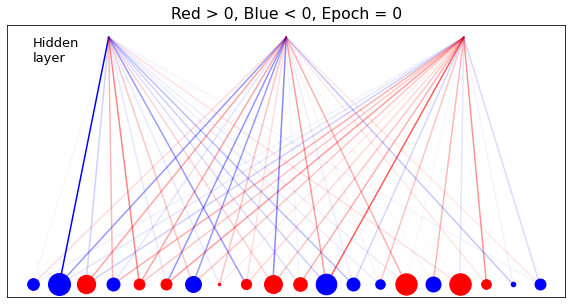

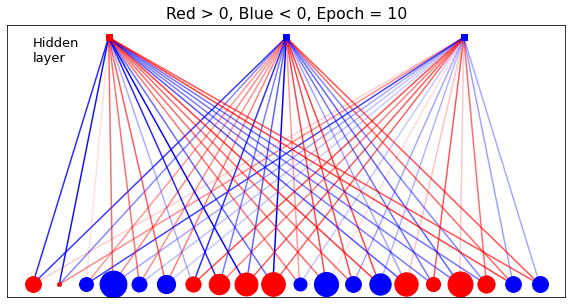

l_rate = 0.02


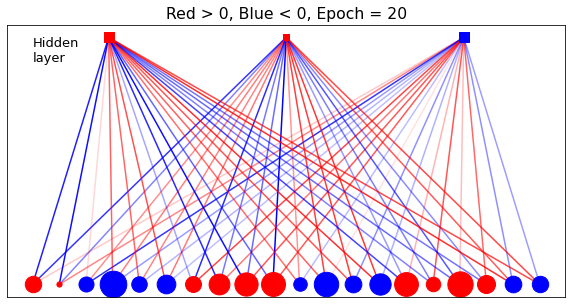

l_rate = 0.02


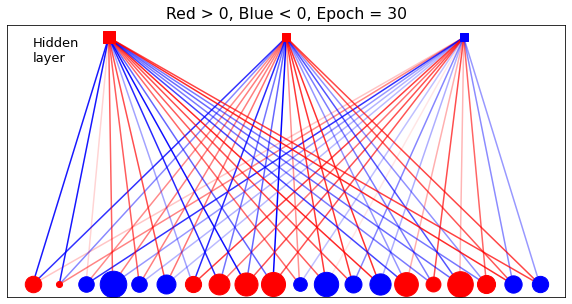

l_rate = 0.02


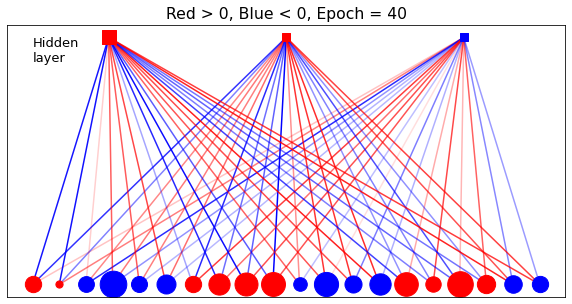

l_rate = 0.02


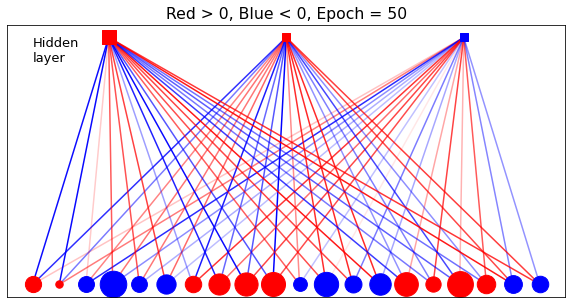

l_rate = 0.02


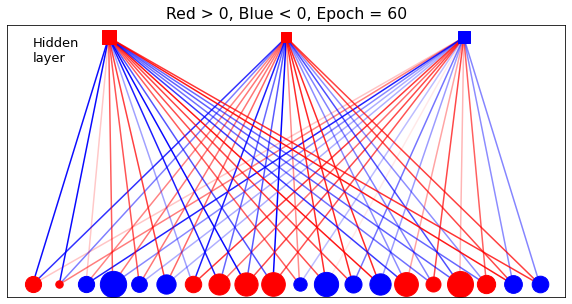

l_rate = 0.02


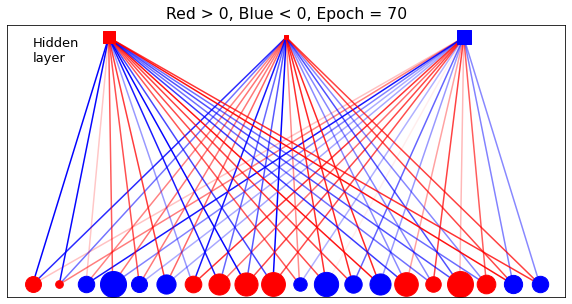

l_rate = 0.02


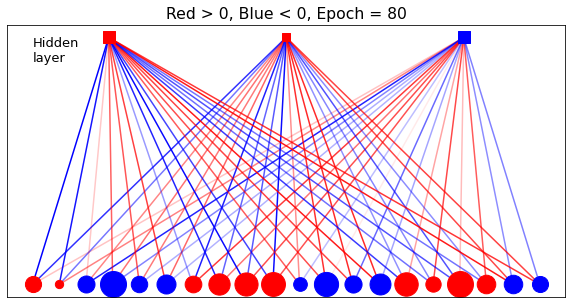

l_rate = 0.02


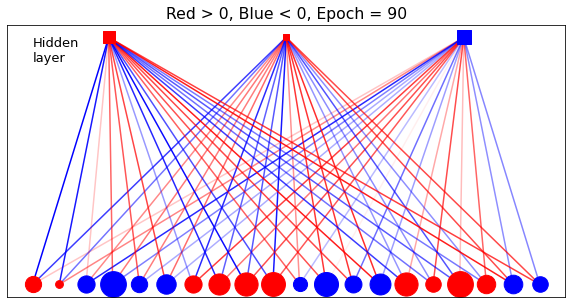

l_rate = 0.02


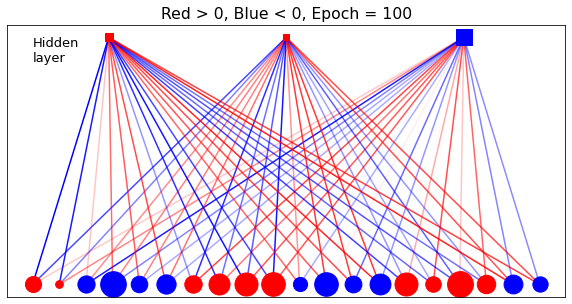

l_rate = 0.02


In [29]:
# Learning rate
lrate = 0.02

# Minibatch size and count
m_size, m_count = 500, 0

# model parameters
beta1 = 0.9
beta2 = 0.999 #for ADAM
eps = 1e-9

# Initializing values at 0
sw, mw = 0, 0
sa, ma = 0, 0
sb, mb = 0, 0

# Choose between 'rmsprop', 'adam', 'vanilla'
model = 'adam'

# Number of CD steps
CD_steps = 1

# Number of epochs
n_epochs = 100
ampl=40.

LogL = []
mean_energy = []
recon_error = []
r_2 = []
entropy = []
cross_entropy = []

plotgraph(0)

# Train model
for epoch in range(n_epochs):
    En = []
    # aggregate normalization of batch statistics and learning rate
    lrate_m = lrate /1

    # Loop over visible units
    for k in range(N):
          
        if m_count == 0:
            # initialization step in the minibatch
            v_data, v_model = np.zeros(L), np.zeros(L)
            h_data, h_model = np.zeros(M), np.zeros(M)
            vh_data, vh_model = np.zeros((L, M)), np.zeros((L, M))

        # CD Positive phase: generate h
        h = activate(v[k], w, b, phase=1)
        
        # CD Negative phase: generate fantasy vf
        vf = activate(h, w.T, a, phase=0)

        # More CD steps
        for i in range(CD_steps - 1):
            hf = activate(vf, w, b, phase=1)
            vf = activate(hf, w.T, a, phase=0)

        # Positive CD phase: fantasy hf from fantasy vf
        hf = activate(vf, w, b, phase=1)
        
        En.append(Energy(v[k], h, w, a, b))

        # Update quantities
        v_data += v[k] / m_size
        v_model += vf / m_size
        h_data += h / m_size
        h_model += hf / m_size
        vh_data += np.outer(v[k].T, h)
        vh_model += np.outer(vf.T, hf)

        m_count += 1
        if m_count == m_size: # End of minibatch
            
            vh_data /= m_size
            vh_model /= m_size            
                        
            # Vanilla GD
            if model == 'vanilla':
                dw = lrate_m * (vh_data - vh_model)
                da = lrate_m * (v_data - v_model)
                db = lrate_m * (h_data - h_model)
            
            # RMSprop
            elif model == 'rmsprop':
                sw, dw = rmsprop(vh_data, vh_model, sw,
                                 beta1, eps, lrate_m)
                sa, da = rmsprop(v_data, v_model, sa,
                                 beta1, eps, lrate_m)
                sb, db = rmsprop(h_data, h_model, sb,
                                 beta1, eps, lrate_m)
            # ADAM
            elif model == 'adam':
                mw, sw, dw = adam(vh_data, vh_model, mw, sw, epoch,
                                  beta1, beta2, eps, lrate_m)
                ma, sa, da = adam(v_data, v_model, ma, sa, epoch,
                                  beta1, beta2, eps, lrate_m)
                mb, sb, db = adam(h_data, h_model, mb, sb, epoch,
                                  beta1, beta2, eps, lrate_m)
                                
            w = w + dw
            a = a + da
            b = b + db
            
            m_count = 0 # move to the next minibatch               
    
    # Shuffle input data
    npr.shuffle(v)
    
    # Decrease the learning rate if not using ADAM
    if (model != 'adam'):
        lrate = lrate / (1 + 0.01 * lrate)
    

    if epoch % 10 == 9:
        
        plotgraph(epoch+1)
        #if (model != 'adam'):
        #    print(f'l_rate = {lrate}')
        print(f'l_rate = {lrate}')   
        
    
    mean_energy.append(np.mean(En))
    
    logZ = np.log(PartZ(w, a, b))
    LogL.append(-np.mean(En)-logZ)
   
    recon_error.append((np.mean(np.abs((v_data - v_model)))))
    
    data_mean = np.mean(v_data)
    SS_tot = np.sum((v_data - data_mean)**2)
    SS_res = np.sum((v_data - v_model)**2)
    r2_acc = 1 - (SS_res / SS_tot)
    
    r_2.append(r2_acc)#1-((np.sum((v_data-v_model)**2))/np.sum((v_data-np.mean(v_data))**2)))
    
    #cross_entropy.append(categorical_cross_entropy(v_data, v_model))
    
    entropy.append(s(v_data, v_model))

In [30]:
# setting time-step for plots ticks
time_step = np.arange(10, n_epochs+10, step=10)

In [31]:
# saving log-likelihood

str_file_l = './Log/log_'+ dname + '_model-' + model + '_mini-' + str(m_size) + '_nep-' + str(n_epochs)
run_info = 'mini: ' + str(m_size) + ', opt: ' + model + ', epochs:  '+ str(n_epochs) + ', lrate: ' + str(lrate) + ', eps:' + str(eps)+ ', CD-n: ' + str(CD_steps) + ', ampl:' + str(ampl)
#np.savetxt(str_file + '.loglike', str(run_info))
np.savetxt(str_file_l + '_10.txt', LogL, header=str(run_info) +'\n' , delimiter=' ')

In [32]:
# saving other metrics

str_file_m = './Mod/mod_'+ dname + '_model-' + model + '_mini-' + str(m_size) + '_nep-' + str(n_epochs)
run_info = 'mini: ' + str(m_size) + ', opt: ' + model + ', epochs:  '+ str(n_epochs) + ', lrate: ' + str(lrate) + ', eps:' + str(eps)+ ', CD-n: ' + str(CD_steps) + ', ampl:' + str(ampl)

# saving recon_error, accuracy, cross_entropy, entropy
data_col = np.column_stack([recon_error, r_2, entropy]) #cross_entropy, entropy])
np.savetxt(str_file_m + '_10.txt', data_col, header=str(run_info) +'\n' , delimiter='\t')

## Evolution of the loglikelihood

The loglikelihood is a measure of how well the RBM model fits the input data. It is defined as the logarithm of the likelihood function, which is the probability of the input data given the model parameters.

The loglikelihood is between -$\infty$ and 0, as the likelihood function $\in [0,1]$. This means that we want to minimize the negative loglikelihood during training. This is typically done using gradient-based optimization methods, such as stochastic gradient descent or RMSProp, to adjust the weights of the RBM model. 
As the negative loglikelihood increases, the model becomes better at capturing the underlying distribution of the input data, and is more likely to generate high-quality samples.

It is also common to use the loglikelihood per data point as a metric, as this is more easily comparable across datasets of different sizes. The loglikelihood can also be used to compare different models or hyperparameters, as models with lower loglikelihoods are generally considered to be better at capturing the underlying distribution of the data.

In [33]:
import glob
filenames_rms = sorted(glob.glob('./Log/log_DATA_b_model-rmsprop_mini-500_nep-100_*.txt'))

mean_rms_stack=[]

for f in filenames_rms:
    #print(f)
    
    log_rmsprop = np.loadtxt(fname=f)
    rms_stack = np.array(np.stack(log_rmsprop, axis=0))
    mean_rms_stack.append(rms_stack)


# Calculating the mean of the log-likelihood over 10 runs
log_mean_rms = np.mean(mean_rms_stack, axis=0)
log_std_rms = np.std(mean_rms_stack, axis=0)

In [34]:
filenames_adam = sorted(glob.glob('./Log/log_DATA_b_model-adam_mini-500_nep-100_*.txt'))

mean_adam_stack=[]

for f in filenames_adam:
    #print(f)
    
    log_adam = np.loadtxt(fname=f)
    adam_stack = np.array(np.stack(log_adam, axis=0))
    mean_adam_stack.append(adam_stack)


# Calculating the mean of the log-likelihood over 10 runs
log_mean_adam = np.mean(mean_adam_stack, axis=0)
log_std_adam = np.std(mean_adam_stack, axis=0)

In [ ]:
"""
filenames_va = sorted(glob.glob('./Log/log_DATA_b_model-vanilla_mini-500_nep-150_*.txt'))

mean_va_stack=[]
std_va=[]

for f in filenames_va:
    #print(f)
    
    log_va = np.loadtxt(fname=f)
    va_stack = np.array(np.stack(log_va, axis=0))
    mean_va_stack.append(va_stack)


# Calculating the mean of the log-likelihood over 10 runs
log_mean_va = np.mean(mean_va_stack, axis=0)
log_std_va = np.std(mean_va_stack, axis=0)
"""

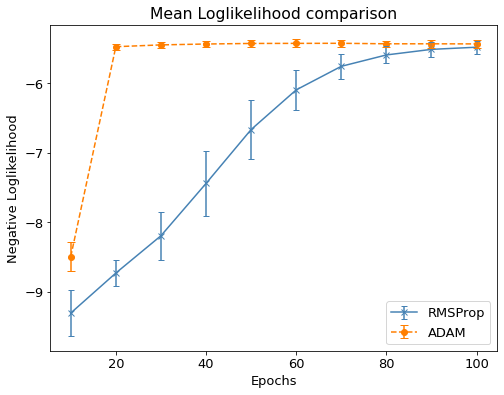

In [149]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.errorbar(time_step, log_mean_rms[0::10], yerr=log_std_rms[0::10], barsabove=True, marker='x', capsize=3, label="RMSProp", color='steelblue')
ax.errorbar(time_step, log_mean_adam[0::10], yerr=log_std_adam[0::10], barsabove=True, marker='o', linestyle='--', capsize=4, label="ADAM", color='#ff7f00')

#ax.errorbar(time_step, log_mean_va[0::10], barsabove=True, marker='o', capsize=3, label="Vanilla")

ax.set_xlabel('Epochs')
ax.set_ylabel('Negative Loglikelihood')
ax.set_title('Mean Loglikelihood comparison')

ax.legend(loc="best")

When using negative Loglikelihood as a metric, it appears that ADAM is the "most effective" optimizer for our model. Ideally, we expect the negative loglikelihood to increase very rapidly in the initial epochs and then stabilize for the remainder of the training. Furthermore, in 10 separate training sessions with identical parameters, there is not significant deviation from the mean value, indicating that the model is optimized correctly.  
Although it is evident that the negative loglikelihood of RMSProp follows the ideal trend, we have decided to disregard it due to the fact that growth did not occur within the first few epochs of training, despite it stabilize at values similar to those of ADAM at around 100 epochs.  
Additionally, the error bars for RMSProp indicate that the various training sessions were not particularly consistent with one another, unlike those for ADAM.

## Best model metrics plots


### Reconstruction error, Accuracy, Loss function and Entropy

To compute the loss function and accuracy for a RBM, we need to define the objective function and the evaluation metric. The objective function is typically the negative log-likelihood of the training data (see before), while the evaluation metric is often the reconstruction error or the classification accuracy on a held-out test set. <!---Here we present also a Loss function: the Cathegorical Cross-Entropy Loss. It measures the difference between the predicted probability distribution and the true probability distribution of the classes. The cross-entropy loss penalizes the model more heavily for making confident incorrect predictions, and less heavily for making less confident incorrect predictions. This can help to prevent overfitting and improve the generalization performance of the model-->.

The evaluation metric for a RBM can vary depending on the specific problem and dataset. In our case, we are using the RBM for feature learning, we might use the reconstruction error as the evaluation metric. A reconstruction error of zero is typically not achievable or desirable, as it would indicate that the RBM model is overfitting to the training data and may not generalize well to new data.

Entropy is an indicator to compare the true and the generated datasets.

Based on the negative loglikelihood, we will now exclusively utilize scores derived from ADAM moving forward.

In [ ]:
filenames_mod = sorted(glob.glob('./Mod/mod_DATA_b_model-adam_mini-500_nep-100_*.txt'))

mean_recon_stack=[]
mean_acc_stack=[]
#mean_cross_stack=[]
mean_ent_stack=[]

for f in filenames_mod:
    mod_rmsprop = np.loadtxt(fname=f)
    
    for j in range(4):
        recon_e = mod_rmsprop[:,0]
        accuracy = mod_rmsprop[:,1]
        #cross_ent = mod_rmsprop[:,2]
        #cross_ent = cross_ent/np.max(cross_ent)
        entropy_e = mod_rmsprop[:,2]
        
        
        recon_stack = np.array(np.stack(recon_e, axis=0))
        acc_stack = np.array(np.stack(accuracy, axis=0))
        #cross_stack = np.array(np.stack(cross_ent, axis=0))
        ent_stack = np.array(np.stack(entropy_e, axis=0))
        
        mean_recon_stack.append(recon_stack)
        mean_acc_stack.append(acc_stack)
        #mean_cross_stack.append(cross_stack)
        mean_ent_stack.append(ent_stack)


# Calculating the mean of the log-likelihood over 10 runs
recon_mean_rms = np.mean(mean_recon_stack, axis=0)
recon_std_rms = np.std(mean_recon_stack, axis=0)

acc_mean_rms = np.mean(mean_acc_stack, axis=0)
acc_std_rms = np.std(mean_acc_stack, axis=0)

#cross_mean_rms = np.mean(mean_cross_stack, axis=0)
#cross_std_rms = np.std(mean_cross_stack, axis=0)

ent_mean_rms = np.mean(mean_ent_stack, axis=0)
ent_std_rms = np.std(mean_ent_stack, axis=0)

"""
recon_e = data_pl[:,0]
accuracy = data_pl[:,1]
cross_ent = data_pl[:,2]
cross_ent /= cross_ent[-1]
entropy_e = data_pl[:,3]
"""

Text(0, 0.5, 'Entropy')

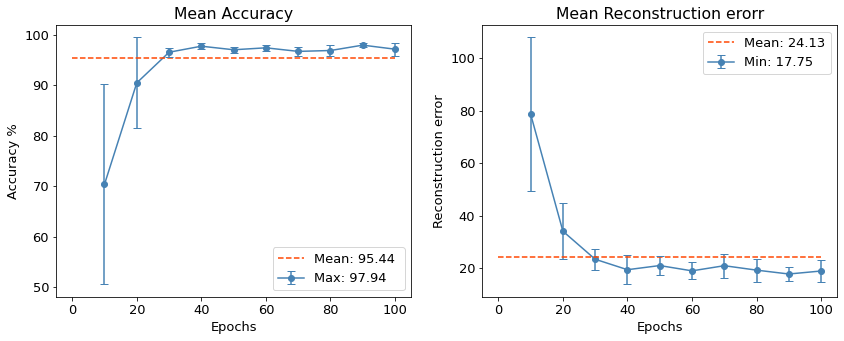

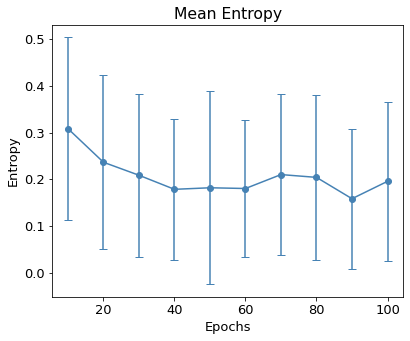

In [154]:
fig1, ax1 = plt.subplots(1,2, figsize=(14, 5))

ax1[0].errorbar(time_step, acc_mean_rms[::10], yerr=acc_std_rms[::10], barsabove=True, marker='o', capsize=4, color='steelblue', label="Max: %.2f"%(np.max(acc_mean_rms[::10])))
ax1[0].hlines(np.mean(acc_mean_rms), 0,100, color='orangered', linestyle='--', label='Mean: %.2f '%(np.mean(acc_mean_rms)) )
ax1[0].set_title('Mean Accuracy')
ax1[0].set_xlabel('Epochs')
ax1[0].set_ylabel('Accuracy %')
ax1[0].legend(loc='lower right')


ax1[1].errorbar(time_step, recon_mean_rms[::10], yerr=recon_std_rms[::10], barsabove=True, marker='o', capsize=4, color='steelblue',label="Min: %.2f"%(np.min(recon_mean_rms[::10])))
ax1[1].hlines(np.mean(recon_mean_rms), 0,100, color='orangered', linestyle='--', label='Mean: %.2f'%(np.mean(recon_mean_rms)))
ax1[1].set_title('Mean Reconstruction erorr')
ax1[1].set_xlabel('Epochs')
ax1[1].set_ylabel('Reconstruction error')
ax1[1].legend(loc='best')

fig2, ax = plt.subplots(1,1, figsize=(6.3,5))

ax.errorbar(time_step, ent_mean_rms[::10], yerr=ent_std_rms[::10], barsabove=True, marker='o', capsize=4, color='steelblue', label="Entropy")
ax.set_title('Mean Entropy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Entropy')

As previously mentioned, accuracy, reconstruction error and entropy are key indicators of the model's ability to generate a new dataset based on the original one.

The mean accuracy indicates that the model quickly learned (i.e., in the first 20 epochs) to generate a new dataset similar to the original one, reaching a maximum accuracy value of 97.94%. The same trend can be observed in the reconstruction error graph, where errors decrease rapidly in the first 20 epochs, then stabilize around 20 errors, with a minimum value around 17.  

While the entropy has generally low values, it should decrease as the number of epochs increases, since the discrepancies between the original data and the generated data should decrease over time. In this case, there is only a slight decrease in the entropy value, but not the trend one would expect. Furthermore, the error bars are quite wide. The problem is likely due to an incorrect definition of the function used to calculate entropy `s(v,vf)`, which we cannot fix due to time constraints.

Although the information obtained from the evolution of entropy is inconclusive, the other metric scores show that the model converges very quickly and adequately.


## Weights matrixes

A weight matrix was created for each hidden unit in order to more clearly visualize the weights distribution, as already shown in the graphs during the training phase.  
The x-axis indicates the block number, consisting of 4 bits, in the sequence. The y-axis indicates the position of the bit within each block. In total there are 20 cells, which correspond to the number of visible units in the sequence.  

The colors indicate whether the weight value is more (red - positive) or less (blue - negative) "heavy".  
A pattern is clearly visible: an alternation of pairs of negative and positive weights, both within the block and between the blocks themselves. This alternation, which was understood and learned by the RBM, was used by us, with prior knowledge, to identify those blocks that referred to polar and non-polar proteins. It is also possible to note that the weights of the first two hidden units are very positive/negative, while those of the remaining hidden unit are close to 0. These results indicate that the connections between the visible units and this hidden unit are not very strong, and for this reason, the RBM model, using ADAM, would have found convergence even with only two hidden units.

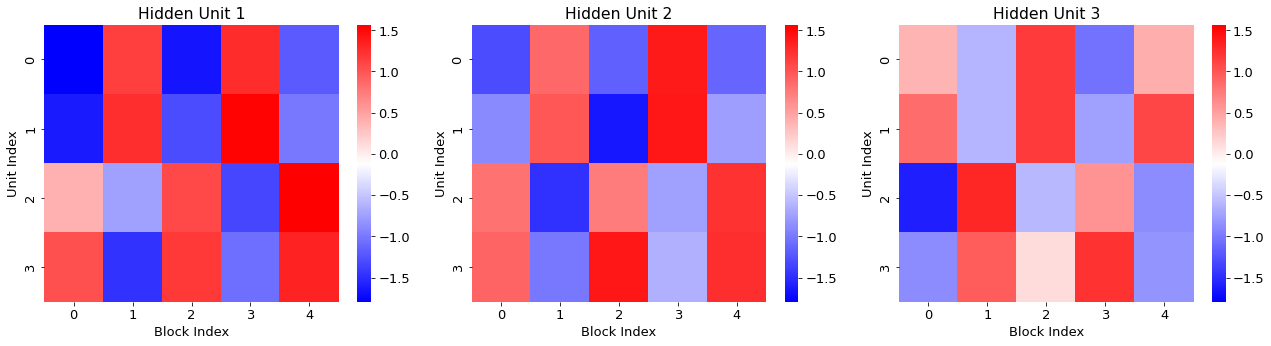

In [40]:
# create a random matrix of size (10,5)
A = A # number of input features
G = M # number of hidden units
w_c = np.copy(w)
a_c = np.copy(a)
min_a = min(a_c)
max_a = max(a_c)

min_w=[]
max_w=[]

a_c = a_c.reshape(L//A, A)
a_c = a_c.T

fig, ax = plt.subplots(ncols=G, nrows=1, figsize=(18, 5))

for i in range(G):
    w_cm = w_c[:,i].reshape(L//A, A)
    w_cm = w_cm.T
        
    min_w.append(np.min(w_cm))
    max_w.append(np.max(w_cm))
    
    sns.heatmap(w_cm, annot=False, cmap='bwr', ax=ax[i], vmin=min(min_w), vmax=max(max_w), cbar=True)
    ax[i].set_title(f'Hidden Unit {i+1}')
    ax[i].set_xlabel('Block Index')
    ax[i].set_ylabel('Unit Index')

fig.tight_layout()    

## Noise reduction

In this section, we present a snapshot demonstrating how our RBM was able to recreate a dataset similar to the original one and understand the real pattern among the blocks of bits in the various sequences. The generated dataset was then used to denoise the original one from spurious bits.

In [39]:
# large GAP <-> low temperature
GAP *= 40

# original, non-reshuffled data is in v_0
v_1 = np.zeros_like(v_0)
for k in range(N):
    # positive CD phase: generate h
    h = activate(v_0[k], w, b, phase=1)
    # negative CD phase: generating fantasy vf
    v_1[k] = activate(h, w.T, a, phase=0)

# difference between model and data
diff = (v_1 - v_0) / 2
# save files with data
str0 = fname + '_M' + str(M) + '-mini' + str(m_size)
np.savetxt(str0 + '.fantasy', (v_1 + 1) / 2, fmt='%d', delimiter=' ')
np.savetxt(str0 + '.diff', diff, fmt='%d', delimiter=' ')

# cut full dataset to first nrows rows
nrows = 20
data = np.copy(v_0[:nrows])
pred = np.copy(((v_1[:nrows] - VMIN) / (1 - VMIN)).astype(int))

# convert one-hot encoding to polar/non-polar flags
one_per_block = range(0, v_0.shape[1], A)
for i in one_per_block:
    data[:, i] = np.argmax(data[:, i:(i + A)], axis=1)
    pred[:, i] = np.argmax(pred[:, i:(i + A)], axis=1)
data = pd.DataFrame(data[:, one_per_block])
pred = pd.DataFrame(pred[:, one_per_block])
thresh = A // 2
data[data < thresh] = 0
data[data >= thresh] = 'P'
pred[pred < thresh] = 0
pred[pred >= thresh] = 'P'
data[data == 0] = 'N'
pred[pred == 0] = 'N'


# appearence
data = data.style.set_table_attributes("style='display:inline'")
pred = pred.style.set_table_attributes("style='display:inline'")

def is_polar(cell_value):
    color0 = 'background-color: gray; color: white'
    color1 = 'background-color: gold; color: black'
    if cell_value == 'P':
        return color1
    return color0
data.applymap(is_polar)
pred.applymap(is_polar)

sty = [dict(selector='caption', props=[('font-size', '150%')])]
data.set_caption('Data').set_table_styles(sty)
pred.set_caption('Model').set_table_styles(sty)

display_html(data._repr_html_() + pred._repr_html_(), raw=True)

,0,1,2,3,4
0,P,N,P,N,P
1,P,N,P,N,P
2,P,N,P,N,P
3,N,P,N,P,N
4,P,P,N,P,N
5,P,N,P,N,P
6,P,N,P,N,N
7,P,N,P,N,P
8,N,P,N,N,N
9,P,N,P,N,P


## Conclusions

The aim of this project was to build a RBM to generate a biological dataset, implementing it with various methods to improve its performance. 

After deciding to use the dataset in its original form (i.e., with `[0, 1]` bits), we trained the model using two different optimizers: `ADAM` and `RMSProp`. During the preliminary training, we searched for the parameters that provided the best results. We then used each optimizer for 10 consecutive training sessions to obtain the average values of the various metric scores and perform statistical analysis.

Using negative log-likelihood as a comparison between the two models, the results showed that `ADAM` was the better optimizer. We therefore used the scores obtained from training with ADAM to verify the performance of the model. The accuracy and the reconstruction errors showed that the model worked correctly. The entropy values were not exhaustive.

The weight matrices clearly show how the model identified and learned the pattern within the blocks of bits, allowing for the generation of a new dataset and denoising operation of the original dataset.